# Preprocessing Data to `protein_embeddings.parquet`
The following cells were used to first preprocess the train.csv file to create the mutated sequences. Then, we run the ESM model to get the embeddings and store these in a parquet file for later use.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('train.csv')

# get the sequence
seq = open('sequence.fasta', 'r').read()
seq = seq.split("\n")[1]

# create each mutated sequence using the info
sequences = []
for i in df['mutant']:
    ind = int(i[1:-1])
    tmp = seq[:ind] + i[-1] + seq[ind+1:]
    sequences.append(tmp)
df['Sequence'] = sequences

In [2]:
import torch
import esm

# Check for GPU
device = 'cpu'
if torch.cuda.is_available():
    device='cuda'
elif torch.mps.is_available():
    device='mps'
print(f"Using device: {device}")

# Load pre-trained ESM model and move it to GPU
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()  # Example: ESM-2 model
batch_converter = alphabet.get_batch_converter()
esm_model = esm_model.to(device)
esm_model.eval()  # Set to eval mode

# Extract ESM embeddings using GPU
def extract_esm_embedding(sequence):
    batch_labels, batch_strs, batch_tokens = batch_converter([(None, sequence)])
    batch_tokens = batch_tokens.to(device)  # Move input to GPU

    with torch.no_grad():
        results = esm_model(batch_tokens, repr_layers=[33], return_contacts=False)
    
    token_representations = results["representations"][33]  # Use final layer
    sequence_embedding = token_representations.mean(dim=1).squeeze().cpu().numpy()  # Move back to CPU for NumPy
    return sequence_embedding

Using device: cuda


In [3]:
df_query3 = pd.read_csv('query3.csv')
df_query3.rename(columns={"sequence": "Sequence"}, inplace=True)
df_query3['Embedding'] = df_query3['Sequence'].apply(lambda seq: extract_esm_embedding(seq))

In [5]:
df = pd.concat([df, df_query3], ignore_index=True)

In [6]:
# load and merge in query 1 results
df_query1 = pd.read_csv('query1.csv')
df_query1.rename(columns={"sequence": "Sequence"}, inplace=True)

df = pd.concat([df, df_query1], ignore_index=True)

In [43]:
# Apply embedding extraction
df["Embedding"] = df["Sequence"].apply(lambda seq: extract_esm_embedding(seq))

df.to_parquet("protein_embeddings.parquet", engine="pyarrow")

In [5]:
df = pd.read_parquet('protein_embeddings.parquet')

In [7]:
df.to_parquet('protein_embeddings_q3.parquet')

# Training Models
We initially train a MLP, LightGBM, and XGBoost.

In [21]:
df = pd.read_parquet('protein_embeddings_q3.parquet')
# df = pd.read_parquet('full_training.parquet')

In [22]:
df.shape

(1440, 4)

In [23]:
import pandas as pd
import numpy as np

# --- Define Amino Acid Properties ---
# (Expanded example with more properties)

# Sources for values can include textbooks, review articles, or online databases like AAindex.
# Make sure to note the scale/source if it matters (e.g., different hydrophobicity scales exist).
aa_properties = {
    # AA: {prop1: val1, prop2: val2, ...}
    'A': {'hydro_KD': 1.8,  'volume': 88.6,  'charge': 0, 'polarity': 8.1, 'flexibility': 0.357},
    'R': {'hydro_KD': -4.5, 'volume': 173.4, 'charge': 1, 'polarity': 10.5, 'flexibility': 0.529},
    'N': {'hydro_KD': -3.5, 'volume': 114.1, 'charge': 0, 'polarity': 11.6, 'flexibility': 0.463},
    'D': {'hydro_KD': -3.5, 'volume': 111.1, 'charge': -1, 'polarity': 13.0, 'flexibility': 0.511},
    'C': {'hydro_KD': 2.5,  'volume': 108.5, 'charge': 0, 'polarity': 5.5, 'flexibility': 0.346},
    'Q': {'hydro_KD': -3.5, 'volume': 143.8, 'charge': 0, 'polarity': 10.5, 'flexibility': 0.493},
    'E': {'hydro_KD': -3.5, 'volume': 138.4, 'charge': -1, 'polarity': 12.3, 'flexibility': 0.497},
    'G': {'hydro_KD': -0.4, 'volume': 60.1,  'charge': 0, 'polarity': 9.0, 'flexibility': 0.544},
    'H': {'hydro_KD': -3.2, 'volume': 153.2, 'charge': 0, 'polarity': 10.4, 'flexibility': 0.323}, # Note: Charge is pH dependent; 0 here is simplified neutral form
    'I': {'hydro_KD': 4.5,  'volume': 166.7, 'charge': 0, 'polarity': 5.2, 'flexibility': 0.462},
    'L': {'hydro_KD': 3.8,  'volume': 166.7, 'charge': 0, 'polarity': 4.9, 'flexibility': 0.365},
    'K': {'hydro_KD': -3.9, 'volume': 168.6, 'charge': 1, 'polarity': 11.3, 'flexibility': 0.466},
    'M': {'hydro_KD': 1.9,  'volume': 162.9, 'charge': 0, 'polarity': 5.7, 'flexibility': 0.295},
    'F': {'hydro_KD': 2.8,  'volume': 189.9, 'charge': 0, 'polarity': 5.2, 'flexibility': 0.314},
    'P': {'hydro_KD': -1.6, 'volume': 112.7, 'charge': 0, 'polarity': 8.0, 'flexibility': 0.509}, # Proline is conformationally restricted
    'S': {'hydro_KD': -0.8, 'volume': 89.0,  'charge': 0, 'polarity': 9.2, 'flexibility': 0.507},
    'T': {'hydro_KD': -0.7, 'volume': 116.1, 'charge': 0, 'polarity': 8.6, 'flexibility': 0.444},
    'W': {'hydro_KD': -0.9, 'volume': 227.8, 'charge': 0, 'polarity': 5.4, 'flexibility': 0.305},
    'Y': {'hydro_KD': -1.3, 'volume': 193.6, 'charge': 0, 'polarity': 6.2, 'flexibility': 0.420},
    'V': {'hydro_KD': 4.2,  'volume': 140.0, 'charge': 0, 'polarity': 5.9, 'flexibility': 0.386},
    # Handle non-standard/unknown amino acids if necessary
    'X': {'hydro_KD': np.nan, 'volume': np.nan, 'charge': np.nan, 'polarity': np.nan, 'flexibility': np.nan},
    '-': {'hydro_KD': np.nan, 'volume': np.nan, 'charge': np.nan, 'polarity': np.nan, 'flexibility': np.nan} # Gap character
}

# --- How to use it in your feature engineering function ---
# (Integrating with the previous code example structure)

def calculate_features_with_props(row, properties_dict):
    wt_aa = row['WT_AA']
    mut_aa = row['Mutant_AA']
    features = {}

    # Get properties
    wt_props = properties_dict.get(wt_aa, properties_dict.get('X')) # Default to 'X' if AA not found
    mut_props = properties_dict.get(mut_aa, properties_dict.get('X'))

    # Create features for each property
    for prop_name in wt_props.keys(): # Iterate through property names (hydro_KD, volume, etc.)
        wt_val = wt_props[prop_name]
        mut_val = mut_props.get(prop_name, np.nan) # Get corresponding mutant prop

        features[f'wt_{prop_name}'] = wt_val
        features[f'mut_{prop_name}'] = mut_val

        # Calculate the difference (Delta feature)
        if pd.notna(wt_val) and pd.notna(mut_val):
            features[f'delta_{prop_name}'] = mut_val - wt_val
        else:
            features[f'delta_{prop_name}'] = np.nan

    # ... add other features like position, one-hot encoding, etc. ...
    features['position'] = row['Position']

    return pd.Series(features)

# --- Example Usage with your DataFrame 'df' ---
# Assuming df has 'WT_AA' and 'Mutant_AA' columns

# df = pd.read_csv('../train.csv')

def add_physical(df):
    df['WT_AA'] = df["mutant"].apply(lambda seq: seq[0])
    df['Mutant_AA'] = df["mutant"].apply(lambda seq: seq[-1])
    df['Position'] = df["mutant"].apply(lambda seq: int(seq[1:-1]))

    feature_df = df.apply(lambda row: calculate_features_with_props(row, aa_properties), axis=1)
    return feature_df

# # ... proceed with combining features, handling NaNs, splitting data, training ...
# print(feature_df.head())


In [24]:
feature_df = add_physical(df)
df = pd.concat((df, feature_df),axis=1)

In [25]:
df.shape

(1440, 23)

In [26]:
import numpy as np

def parse_pssm(pssm_path):
    pssm = []
    with open(pssm_path, "r") as f:
        start = False
        for line in f:
            if line.strip().startswith("Last position-specific scoring matrix computed"):
                start = True
                next(f)  # skip header
                continue
            if start:
                if not line.strip():
                    break
                values = line.strip().split()
                scores = [int(x) for x in values[2:22]]  # 20 AA scores
                pssm.append(scores)
    return np.array(pssm)  # shape: [L, 20]


aa_to_index = {
    'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4,
    'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9,
    'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14,
    'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19
}

def get_pssm_features(pssm, pos, wt_aa, mut_aa):
    wt_idx = aa_to_index[wt_aa]
    mut_idx = aa_to_index[mut_aa]
    wt_score = pssm[pos][wt_idx]
    mut_score = pssm[pos][mut_idx]
    delta = mut_score - wt_score
    return [wt_score, mut_score, delta]


def get_pssm_df(df):
    pssm = parse_pssm('pssm.txt')
    result = df.apply(
        lambda row: pd.Series(
            get_pssm_features(
                pssm=pssm,
                pos=row['Position'],
                wt_aa=row['mutant'][0],    # First character is wild-type AA
                mut_aa=row['mutant'][-1]   # Last character is mutant AA
            ),
            index=['wt_score', 'mut_score', 'delta_score']
        ),
        axis=1
    )
    
    return result

pssm_df = get_pssm_df(df)

In [27]:
df = pd.concat((df, pssm_df), axis=1)

In [28]:
df.shape

(1440, 26)

Text(0.5, 1.0, 'Total Dataset Labels')

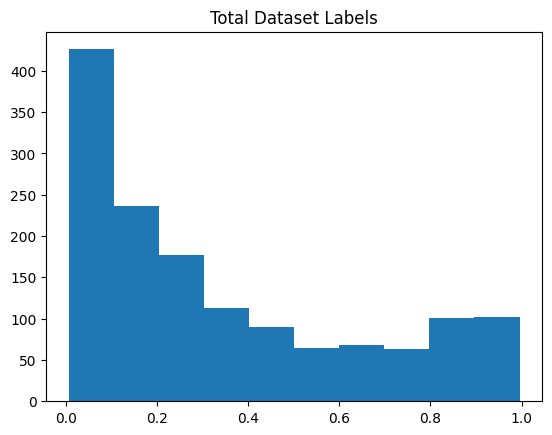

In [15]:
import matplotlib.pyplot as plt
plt.hist(df.DMS_score)
plt.title("Total Dataset Labels")

In [29]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = np.vstack(df["Embedding"].values)
X = np.concatenate((X,feature_df.values), axis=1)
X = np.concatenate((X,pssm_df.values), axis=1)

y = df["DMS_score"].values

# Convert to PyTorch tensors and move to GPU
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)  # Reshape for MLP

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


In [14]:
len(set(df[df['position'] > 355]['position'].values))

117

In [23]:
X.shape

(1440, 1299)

In [24]:
df.to_parquet('full_training.parquet')

## MLP

In [ ]:
from scipy.stats import spearmanr

# Define a simple MLP regression model using GPU
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Single output value
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, loss function, and optimizer
model = MLPRegressor(input_dim=X.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Training loop
epochs = 40000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = criterion(test_predictions, y_test)
print(f"Test MSE: {test_loss.item():.4f}")

spearman_corr_xgb, _ = spearmanr(y_test.cpu().numpy().flatten(), test_predictions.cpu().numpy().flatten())
print(f"MLP Spearman Correlation: {spearman_corr_xgb:.4f}")

modified MLP:

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import spearmanr

# Define a more robust MLP regression model
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),  # Normalization to stabilize training
            nn.ReLU(),
            nn.Dropout(0.2),  # Prevent overfitting
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Custom Spearman-friendly loss function
def spearman_loss(y_pred, y_true):
    return -torch.cosine_similarity(y_pred.view(1, -1), y_true.view(1, -1))

# Initialize model, loss function, and optimizer
model = MLPRegressor(input_dim=X.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-5)  # Weight decay added
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop
epochs = 40000
best_val_loss = float('inf')
patience, patience_counter = 5000, 0  # Early stopping

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    predictions = model(X_train)
    loss = spearman_loss(predictions, y_train)  # Rank-based loss
    loss.backward()
    optimizer.step()
    
    # Learning rate scheduling
    scheduler.step(loss)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Early stopping
    if loss.item() < best_val_loss:
        best_val_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = spearman_loss(test_predictions, y_test)

print(f"Test Spearman Loss: {test_loss.item():.4f}")

# Compute Spearman correlation
spearman_corr, _ = spearmanr(y_test.cpu().numpy().flatten(), test_predictions.cpu().numpy().flatten())
print(f"MLP Spearman Correlation: {spearman_corr:.4f}")


/home/hice1/savunuri3/.conda/envs/compbiohack/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1000/40000, Loss: -0.8913
Epoch 2000/40000, Loss: -0.8821
Epoch 3000/40000, Loss: -0.8895
Epoch 4000/40000, Loss: -0.8874
Epoch 5000/40000, Loss: -0.8919
Epoch 6000/40000, Loss: -0.8903
Early stopping triggered.
Test Spearman Loss: -0.8979
MLP Spearman Correlation: 0.6447


In [31]:
df_test = pd.read_parquet('protein_embeddings_test.parquet')
X_unlabeled = df_test['Embedding'].values
X_unlabeled = np.vstack(X_unlabeled)
feature_df_test = add_physical(df_test)
pssm_df_test = get_pssm_df(df_test)
X_unlabeled = np.concatenate((X_unlabeled, feature_df_test),axis=1)
X_unlabeled = np.concatenate((X_unlabeled, pssm_df_test), axis=1)

X_unlabeled = torch.tensor(X_unlabeled, dtype=torch.float32, device=device)


Predictions for MLP --> Go to Test Set Predictions after running Generating protein_embeddings_test.parquet section

(array([ 185.,  678.,  981., 1232., 1354., 1274., 1932., 3101.,  566.,
          21.]),
 array([0.00988655, 0.11312851, 0.21637046, 0.31961244, 0.42285436,
        0.52609634, 0.62933832, 0.73258024, 0.83582222, 0.9390642 ,
        1.04230607]),
 <BarContainer object of 10 artists>)

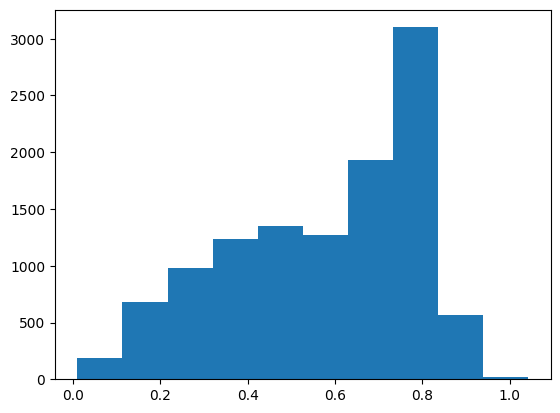

In [37]:
# Rohan's Version
%matplotlib inline
import matplotlib.pyplot as plt
pred = model(X_unlabeled)
pred = pred.detach().cpu().numpy()
plt.hist(pred)

## XGBoost

In [13]:
import xgboost as xgb
from scipy.stats import spearmanr

# Convert to DMatrix (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train.cpu().numpy(), label=y_train.cpu().numpy().flatten())
dtest = xgb.DMatrix(X_test.cpu().numpy(), label=y_test.cpu().numpy().flatten())

# Train XGBoost Model
params = {"objective": "reg:squarederror", "eval_metric": "rmse"}
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict
y_pred_xgb = xgb_model.predict(dtest)

# Compute Spearman correlation
spearman_corr_xgb, _ = spearmanr(y_test.cpu().numpy().flatten(), y_pred_xgb)
print(f"XGBoost Spearman Correlation: {spearman_corr_xgb:.4f}")


XGBoost Spearman Correlation: 0.4610


## LightGBM

In [30]:
import lightgbm as lgb
from scipy.stats import spearmanr

# Train LightGBM Model
lgb_train = lgb.Dataset(X, label=y)

params = {"objective": "regression", "metric": "rmse"}
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)

# # Predict
# y_pred_lgb = lgb_model.predict(X_test.cpu().numpy())

# # Compute Spearman correlation
# spearman_corr_lgb, _ = spearmanr(y_test.cpu().numpy().flatten(), y_pred_lgb)
# print(f"LightGBM Spearman Correlation: {spearman_corr_lgb:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327498
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 1299
[LightGBM] [Info] Start training from score 0.339711


In [89]:
df_test[df_test['Position'] > 350]['DMS_score_predicted'].mean()

np.float64(0.7809952360533243)

In [92]:
df_test.loc[df_test['Position'] > 350, 'DMS_score_predicted'] += .03

In [67]:
df_test[df_test['Position'] < 350]['DMS_score_predicted'].mean()

np.float64(0.41385678821175276)

(array([269., 361., 232., 147.,  96.,  60.,  67.,  70.,  83.,  55.]),
 array([0.02326113, 0.11786246, 0.2124638 , 0.30706513, 0.40166646,
        0.4962678 , 0.59086913, 0.68547046, 0.78007179, 0.87467313,
        0.96927446]),
 <BarContainer object of 10 artists>)

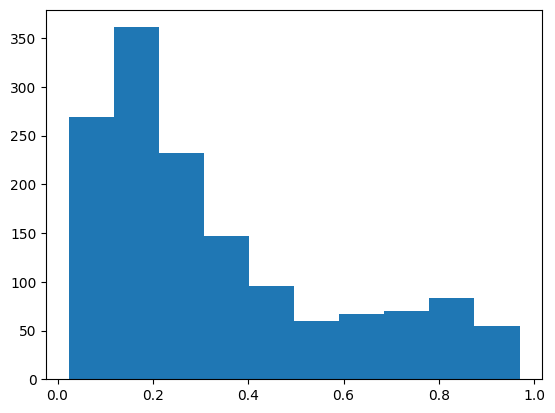

In [62]:
plt.hist(lgb_model.predict(X))

y.shape

In [45]:
pred=lgb_model.predict(X_unlabeled.cpu().numpy())

# Ensemble of LightGBM & Linear Regression 
We use linear regression to weigh the different models in the ensemble instead of taking the mean. We use boostrapping to train each model on a different subset of the data.

In [15]:
y_train.max()

tensor(0.9957, device='cuda:0')

In [36]:
# Step 1 - Train Ensemble
import lightgbm as lgb
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
from sklearn.utils import resample

# Define hyperparameters for LightGBM
lgb_params = {"objective":"regression", "metric": "rmse", 'learning_rate': 0.0436032560500989,  'num_leaves': 76, 'min_child_samples': 6, 'max_depth': 7, 'subsample': 0.5939560221912161, 'colsample_bytree': 0.6618044618804528, }



# Number of bootstrapped models
num_bootstraps = 100
lgb_boot_models = []
lgb_predictions = []

progress = tqdm(total=num_bootstraps, desc="Training Bootstrapped LightGBM Models")

for i in range(num_bootstraps):
    # Bootstrap resampling
    X_resampled, y_resampled = resample(X,y, replace=True, n_samples=X_train.shape[0], random_state=i)

    # Train LightGBM model on resampled data
    lgb_train = lgb.Dataset(X_resampled, label=y_resampled)
    lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=100)
    
    # Store trained model
    lgb_boot_models.append(lgb_model)

    # Predict on test set
    y_pred_lgb = lgb_model.predict(X_test.cpu().numpy())
    lgb_predictions.append(y_pred_lgb)

    progress.update(1)

progress.close()

# Average predictions from bootstrapped models
y_pred_ensemble = np.mean(np.column_stack(lgb_predictions), axis=1)

# Compute Spearman correlation
spearman_corr_ensemble, _ = spearmanr(y_test.cpu().numpy().flatten(), y_pred_ensemble)

print(f"Bootstrapped LightGBM Ensemble Spearman Correlation: {spearman_corr_ensemble:.4f}")


Training Bootstrapped LightGBM Models:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326025
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.349639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Training Bootstrapped LightGBM Models:   1%|          | 1/100 [00:04<07:46,  4.71s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326085
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.336406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:   2%|▏         | 2/100 [00:06<04:39,  2.85s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:   3%|▎         | 3/100 [00:07<03:47,  2.34s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022577 secon

Training Bootstrapped LightGBM Models:   4%|▍         | 4/100 [00:09<03:20,  2.09s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326059
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.346542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:   5%|▌         | 5/100 [00:11<02:59,  1.89s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function <function _log_callback at 0x15547c72b380>:
Traceback (most recent call last):
  File "/home/hice1/savunuri3/.conda/envs/compbiohack/lib/python3.13/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326627
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.343912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:   6%|▌         | 6/100 [00:13<02:55,  1.87s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:   7%|▋         | 7/100 [00:14<02:43,  1.76s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

Training Bootstrapped LightGBM Models:   8%|▊         | 8/100 [00:16<02:40,  1.74s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

Training Bootstrapped LightGBM Models:   9%|▉         | 9/100 [00:17<02:32,  1.68s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022629 secon

Training Bootstrapped LightGBM Models:  10%|█         | 10/100 [00:19<02:33,  1.70s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

Training Bootstrapped LightGBM Models:  11%|█         | 11/100 [00:21<02:27,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

Training Bootstrapped LightGBM Models:  12%|█▏        | 12/100 [00:22<02:29,  1.70s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326023
[LightGBM] [Info] Number of data points in the train

Training Bootstrapped LightGBM Models:  13%|█▎        | 13/100 [00:24<02:25,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  14%|█▍        | 14/100 [00:26<02:23,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326091
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.360510
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  15%|█▌        | 15/100 [00:27<02:19,  1.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  16%|█▌        | 16/100 [00:29<02:20,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325960
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.332372
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  17%|█▋        | 17/100 [00:31<02:14,  1.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

Training Bootstrapped LightGBM Models:  18%|█▊        | 18/100 [00:32<02:15,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326173
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training 

Training Bootstrapped LightGBM Models:  19%|█▉        | 19/100 [00:34<02:12,  1.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  20%|██        | 20/100 [00:36<02:12,  1.66s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325752
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.345977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  21%|██        | 21/100 [00:37<02:08,  1.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  22%|██▏       | 22/100 [00:39<02:09,  1.66s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

Training Bootstrapped LightGBM Models:  23%|██▎       | 23/100 [00:40<02:06,  1.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326099
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.328289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  24%|██▍       | 24/100 [00:42<02:06,  1.66s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  25%|██▌       | 25/100 [00:44<02:04,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326323
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.335800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Training Bootstrapped LightGBM Models:  26%|██▌       | 26/100 [00:48<03:06,  2.52s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326411
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.334730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  27%|██▋       | 27/100 [00:50<02:42,  2.23s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

Training Bootstrapped LightGBM Models:  28%|██▊       | 28/100 [00:52<02:31,  2.11s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326411
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.342675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  29%|██▉       | 29/100 [00:54<02:22,  2.01s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326390
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.348548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  30%|███       | 30/100 [00:55<02:11,  1.87s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

Training Bootstrapped LightGBM Models:  31%|███       | 31/100 [00:57<02:06,  1.83s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325761
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.341588
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  32%|███▏      | 32/100 [00:58<01:57,  1.73s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023024 secon

Training Bootstrapped LightGBM Models:  33%|███▎      | 33/100 [01:00<01:57,  1.76s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

Training Bootstrapped LightGBM Models:  34%|███▍      | 34/100 [01:02<01:50,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325674
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.338945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  35%|███▌      | 35/100 [01:03<01:49,  1.69s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

Training Bootstrapped LightGBM Models:  36%|███▌      | 36/100 [01:05<01:44,  1.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

Training Bootstrapped LightGBM Models:  37%|███▋      | 37/100 [01:07<01:45,  1.68s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326139
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.337006
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  38%|███▊      | 38/100 [01:08<01:40,  1.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023337 secon

Training Bootstrapped LightGBM Models:  39%|███▉      | 39/100 [01:10<01:40,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326257
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.329795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  40%|████      | 40/100 [01:11<01:38,  1.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  41%|████      | 41/100 [01:13<01:36,  1.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

Training Bootstrapped LightGBM Models:  42%|████▏     | 42/100 [01:15<01:33,  1.61s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  43%|████▎     | 43/100 [01:16<01:35,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  44%|████▍     | 44/100 [01:18<01:30,  1.62s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326094
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training 

Training Bootstrapped LightGBM Models:  45%|████▌     | 45/100 [01:20<01:30,  1.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325992
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.332402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  46%|████▌     | 46/100 [01:21<01:28,  1.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325936
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.353665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  47%|████▋     | 47/100 [01:23<01:29,  1.69s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326173
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training 

Training Bootstrapped LightGBM Models:  48%|████▊     | 48/100 [01:25<01:25,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

Training Bootstrapped LightGBM Models:  49%|████▉     | 49/100 [01:26<01:25,  1.68s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326363
[LightGBM] [Info] Number of data points in the train

Training Bootstrapped LightGBM Models:  50%|█████     | 50/100 [01:28<01:22,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  51%|█████     | 51/100 [01:30<01:21,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325566
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.341463
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  52%|█████▏    | 52/100 [01:31<01:18,  1.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  53%|█████▎    | 53/100 [01:33<01:17,  1.66s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326595
[LightGBM] [Info] Number of data points in the train

Training Bootstrapped LightGBM Models:  54%|█████▍    | 54/100 [01:35<01:15,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326216
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.357103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  55%|█████▌    | 55/100 [01:36<01:16,  1.69s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325638
[LightGBM] [Info] Number of data points in the train

Training Bootstrapped LightGBM Models:  56%|█████▌    | 56/100 [01:38<01:13,  1.66s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  57%|█████▋    | 57/100 [01:40<01:12,  1.69s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326141
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.338731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  58%|█████▊    | 58/100 [01:41<01:08,  1.62s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325999
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.347286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  59%|█████▉    | 59/100 [01:43<01:07,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326073
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.339123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  60%|██████    | 60/100 [01:44<01:05,  1.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326316
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.343276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  61%|██████    | 61/100 [01:46<01:05,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326239
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.360424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  62%|██████▏   | 62/100 [01:48<01:02,  1.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326076
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training 

Training Bootstrapped LightGBM Models:  63%|██████▎   | 63/100 [01:50<01:01,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  64%|██████▍   | 64/100 [01:51<00:59,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325970
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.344219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  65%|██████▌   | 65/100 [01:53<00:58,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

Training Bootstrapped LightGBM Models:  66%|██████▌   | 66/100 [01:54<00:56,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325964
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.331583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  67%|██████▋   | 67/100 [01:56<00:54,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  68%|██████▊   | 68/100 [01:58<00:51,  1.62s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

Training Bootstrapped LightGBM Models:  69%|██████▉   | 69/100 [01:59<00:51,  1.66s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326153
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.342653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  70%|███████   | 70/100 [02:01<00:48,  1.61s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325686
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training 

Training Bootstrapped LightGBM Models:  71%|███████   | 71/100 [02:03<00:48,  1.66s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

Training Bootstrapped LightGBM Models:  72%|███████▏  | 72/100 [02:04<00:45,  1.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  73%|███████▎  | 73/100 [02:06<00:44,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326365
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.348297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  74%|███████▍  | 74/100 [02:08<00:43,  1.66s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326191
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.342945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  75%|███████▌  | 75/100 [02:09<00:42,  1.68s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326034
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.339638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  76%|███████▌  | 76/100 [02:11<00:39,  1.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326083
[LightGBM] [Info] Number of data points in the train

Training Bootstrapped LightGBM Models:  77%|███████▋  | 77/100 [02:13<00:38,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023356 secon

Training Bootstrapped LightGBM Models:  78%|███████▊  | 78/100 [02:14<00:35,  1.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

Training Bootstrapped LightGBM Models:  79%|███████▉  | 79/100 [02:16<00:35,  1.68s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  80%|████████  | 80/100 [02:18<00:32,  1.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

Training Bootstrapped LightGBM Models:  81%|████████  | 81/100 [02:19<00:31,  1.68s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326357
[LightGBM] [Info] Number of data points in the train

Training Bootstrapped LightGBM Models:  82%|████████▏ | 82/100 [02:21<00:29,  1.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325925
[LightGBM] [Info] Number of data points in the train

Training Bootstrapped LightGBM Models:  83%|████████▎ | 83/100 [02:23<00:28,  1.68s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

Training Bootstrapped LightGBM Models:  84%|████████▍ | 84/100 [02:24<00:26,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  85%|████████▌ | 85/100 [02:26<00:25,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  86%|████████▌ | 86/100 [02:27<00:22,  1.62s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

Training Bootstrapped LightGBM Models:  87%|████████▋ | 87/100 [02:29<00:21,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326014
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.349413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  88%|████████▊ | 88/100 [02:31<00:19,  1.62s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  89%|████████▉ | 89/100 [02:32<00:18,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  90%|█████████ | 90/100 [02:34<00:16,  1.64s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326082
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.333054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  91%|█████████ | 91/100 [02:36<00:15,  1.70s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326399
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.322865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  92%|█████████▏| 92/100 [02:37<00:13,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325498
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training 

Training Bootstrapped LightGBM Models:  93%|█████████▎| 93/100 [02:39<00:11,  1.69s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  94%|█████████▍| 94/100 [02:41<00:10,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325788
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.333987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  95%|█████████▌| 95/100 [02:43<00:08,  1.69s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326201
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.358285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Training Bootstrapped LightGBM Models:  96%|█████████▌| 96/100 [02:44<00:06,  1.66s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  97%|█████████▋| 97/100 [02:46<00:05,  1.70s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023378 secon

Training Bootstrapped LightGBM Models:  98%|█████████▊| 98/100 [02:48<00:03,  1.66s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Bootstrapped LightGBM Models:  99%|█████████▉| 99/100 [02:49<00:01,  1.69s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

Training Bootstrapped LightGBM Models: 100%|██████████| 100/100 [02:51<00:00,  1.71s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [38]:
# Step 2: Train Meta Predictor

from sklearn.linear_model import Ridge

progress = tqdm(total=len(lgb_boot_models), desc="Generating `X_meta_train`")
X_meta_train = []
for m in lgb_boot_models:
    X_meta_train.append(m.predict(X_train.cpu().numpy()))
    progress.update(1)

progress.close()

X_meta_train = np.column_stack(X_meta_train)
y_meta_train = y_train.cpu().numpy().flatten()


# Train a Ridge Regression as the meta-model
meta_model = Ridge(alpha=1.0)
meta_model.fit(X_meta_train, y_meta_train)

## EVAL::
# Predict with stacked model
progress = tqdm(total=len(lgb_boot_models), desc="Predicting for `X_meta_test`")
X_meta_test = []
for m in lgb_boot_models:
    X_meta_test.append(m.predict(X_test.cpu().numpy()))
    progress.update(1)
progress.close()
X_meta_test = np.column_stack(X_meta_test)
y_meta_test = y_train.cpu().numpy().flatten()

y_meta_pred = meta_model.predict(X_meta_train)

# Compute Spearman correlation
spearman_corr_stacked, _ = spearmanr(y_meta_test, y_meta_pred)
print(f"Meta LightGBM Model Spearman Correlation: {spearman_corr_stacked:.4f}")


Predicting for `X_meta_test`: 100%|██████████| 100/100 [00:00<00:00, 1086.44it/s]

Meta LightGBM Model Spearman Correlation: 0.9466


# Predictions

In [19]:
df_test = pd.read_parquet('protein_embeddings_test.parquet')
X_unlabeled = df_test['Embedding'].values

In [20]:
X_unlabeled = np.vstack(X_unlabeled)
X_unlabeled = torch.tensor(X_unlabeled, dtype=torch.float32, device=device)

In [39]:
import numpy as np

# Compute UCB for LightGBM ensemble

y_pred_all = np.column_stack([model.predict(X_unlabeled.cpu().numpy()) for model in lgb_boot_models])
std_pred = np.std(y_pred_all, axis=1)    # Uncertainty (std dev)
mean_pred = meta_model.predict(y_pred_all)

In [41]:
y_pred = np.mean(y_pred_all, axis=1)

In [28]:
y_pred.shape

(11324,)

In [64]:
np.sort(ucb_scores)[-100:]

array([0.93622144, 0.93659159, 0.93671105, 0.93692133, 0.93708201,
       0.93712556, 0.93804011, 0.93810808, 0.93844395, 0.93917645,
       0.9397838 , 0.94077272, 0.94084303, 0.9409896 , 0.94222454,
       0.94280962, 0.94285374, 0.94285552, 0.94289024, 0.94297554,
       0.94338928, 0.94351852, 0.94392633, 0.94461465, 0.94469756,
       0.94571912, 0.94615883, 0.94623628, 0.94811688, 0.94828959,
       0.94843621, 0.94913811, 0.94974902, 0.94975701, 0.9503925 ,
       0.95055382, 0.95056504, 0.95088919, 0.95104963, 0.95117944,
       0.95226125, 0.95231174, 0.952692  , 0.95386885, 0.95388761,
       0.95541695, 0.95561224, 0.95695288, 0.95731015, 0.95764289,
       0.95950218, 0.9612624 , 0.96193106, 0.96346583, 0.96425935,
       0.96439656, 0.96440709, 0.96458613, 0.96507176, 0.96510841,
       0.96631343, 0.96665065, 0.96831605, 0.96928356, 0.9698309 ,
       0.96992072, 0.97086716, 0.97145376, 0.97172869, 0.97233498,
       0.97307458, 0.97366605, 0.97572577, 0.97653011, 0.97680

In [65]:
# Rohan's Version
ucb_scores = mean_pred
top_mutations = np.argsort(ucb_scores)[-100:]
predicted_top = df_test.iloc[top_mutations]['mutant'].values

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(ucb_scores)

NameError: name 'ucb_scores' is not defined

In [18]:
# Sai's Version
ucb_scores = std_pred
top_mutations = np.argsort(ucb_scores)[-100:]
df_test.iloc[top_mutations]['mutant'].values

array(['L589G', 'E231N', 'E468G', 'W499N', 'L631P', 'L155N', 'F579T',
       'L125G', 'L75T', 'L642G', 'A510G', 'F59G', 'A395G', 'I478G',
       'F514G', 'L639P', 'D624Y', 'E184N', 'A301G', 'A310G', 'L525T',
       'F64G', 'F206G', 'R265P', 'A83G', 'L471T', 'L404P', 'V282G',
       'L466A', 'L627T', 'R265N', 'L273N', 'I487G', 'E427N', 'L627G',
       'E274N', 'F230G', 'R387G', 'L155T', 'L10G', 'A327G', 'I364G',
       'D613N', 'D494N', 'L213N', 'F365G', 'E278G', 'L317M', 'I547G',
       'L407G', 'L125T', 'D288N', 'E414N', 'D244N', 'F563G', 'P626G',
       'L452G', 'L14G', 'L631T', 'F63C', 'I607G', 'L459P', 'L539P',
       'E640N', 'W560T', 'L525P', 'W348P', 'L75P', 'W454N', 'L147G',
       'L466T', 'E166N', 'D37Q', 'F431G', 'E46N', 'A349G', 'F256G',
       'I481G', 'A367G', 'V634G', 'L641G', 'L346T', 'M580G', 'I496G',
       'L300M', 'L155G', 'I181G', 'F405G', 'F238G', 'F434G', 'L620M',
       'D187G', 'I374G', 'L121G', 'L267G', 'W94P', 'F171G', 'L346M',
       'D91G', 'L639G'], dtype=

In [23]:
arr = list(df_test.iloc[top_mutations]['mutant'].values)
f = open('query2.txt','w')
for i in arr:
    f.write(i+'\n')
f.close()

In [24]:
# TODO: Delete me
# test
sai_test = []
with open("query1.txt", "r") as f:
    data = f.read()
    sai_test = data.splitlines()
rohan_test = []
with open("query2.txt", "r") as f:
    data = f.read()
    rohan_test = data.splitlines()

val = len(set(rohan_test) & set(sai_test))
print(val)

100


# Generating protein_embeddings_test.parquet

In [48]:
import torch
import esm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ESM model and move it to GPU
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()  # Example: ESM-2 model
batch_converter = alphabet.get_batch_converter()
esm_model = esm_model.to(device)
esm_model.eval()  # Set to eval mode

# Extract ESM embeddings using GPU
def extract_esm_embedding(sequence):
    batch_labels, batch_strs, batch_tokens = batch_converter([(None, sequence)])
    batch_tokens = batch_tokens.to(device)  # Move input to GPU

    with torch.no_grad():
        results = esm_model(batch_tokens, repr_layers=[33], return_contacts=False)
    
    token_representations = results["representations"][33]  # Use final layer
    sequence_embedding = token_representations.mean(dim=1).squeeze().cpu().numpy()  # Move back to CPU for NumPy
    return sequence_embedding

Using device: cuda


In [49]:
df_test = pd.read_csv('test.csv')
df_test['Sequence'] = df_test['mutant'].apply(lambda x: seq[:int(x[1:-1])] + x[-1] + seq[int(x[1:-1])+1:])
df_test['Embedding'] = df_test['Sequence'].apply(lambda seq: extract_esm_embedding(seq))
df_test.to_parquet("protein_embeddings_test.parquet", engine="pyarrow")

# Finding Optimal Hyperparams for LightGBM

In [43]:
#Best LightGBM Parameters: {'learning_rate': 0.04931791757724383, 'num_leaves': 85, 'min_child_samples': 48, 'max_depth': 7, 'subsample': 0.5749253739933733, 'colsample_bytree': 0.8371746709650121}
import optuna

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    }

    lgb_train = lgb.Dataset(X_train.cpu().numpy(), label=y_train.cpu().numpy().flatten())
    lgb_model = lgb.train(params, lgb_train, num_boost_round=100)
    
    y_pred = lgb_model.predict(X_test.cpu().numpy())
    spearman_corr, _ = spearmanr(y_test.cpu().numpy().flatten(), y_pred)
    
    return spearman_corr

# Run Bayesian Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best parameters
print("Best LightGBM Parameters:", study.best_params)


/home/hice1/savunuri3/.conda/envs/compbiohack/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-03 23:51:32,064] A new study created in memory with name: no-name-b48b2952-dddb-4716-b698-e99141f5ff47
/tmp/ipykernel_889772/1352214443.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
/tmp/ipykernel_889772/1352214443.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327352
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.341060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-04-03 23:51:32,912] Trial 0 finished with value: 0.7275019375154647 and parameters: {'learning_rate': 0.014401217822697869, 'num_leaves': 91, 'min_child_samples': 37, 'max_depth': 7, 'subsample': 0.7755376674206114, 'colsample_bytree': 0.9230241599533326}. Best is trial 0 with value: 0.7275019375154647.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

[I 2025-04-03 23:51:33,539] Trial 1 finished with value: 0.7162924195224707 and parameters: {'learning_rate': 0.10984998401827262, 'num_leaves': 16, 'min_child_samples': 35, 'max_depth': 4, 'subsample': 0.7271379791326014, 'colsample_bytree': 0.8740539260062032}. Best is trial 0 with value: 0.7275019375154647.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-03 23:51:34,267] Trial 2 finished with value: 0.7311872034470147 and parameters: {'learning_rate': 0.028358764032303807, 'num_leaves': 69, 'min_child_samples': 33, 'max_depth': 6, 'subsample': 0.6823265948164037, 'colsample_bytree': 0.8597758876813544}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327352
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.341060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-04-03 23:51:35,095] Trial 3 finished with value: 0.7204614519605749 and parameters: {'learning_rate': 0.05017192947579558, 'num_leaves': 22, 'min_child_samples': 38, 'max_depth': 8, 'subsample': 0.719329392795071, 'colsample_bytree': 0.8855001435347584}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

[I 2025-04-03 23:51:35,796] Trial 4 finished with value: 0.7278370073595682 and parameters: {'learning_rate': 0.0404524987376436, 'num_leaves': 57, 'min_child_samples': 40, 'max_depth': 6, 'subsample': 0.7214296171693783, 'colsample_bytree': 0.9536571652236161}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-03 23:51:37,016] Trial 5 finished with value: 0.7008674013843565 and parameters: {'learning_rate': 0.09264297714100868, 'num_leaves': 82, 'min_child_samples': 29, 'max_depth': 10, 'subsample': 0.5791530810602985, 'colsample_bytree': 0.8328836625271291}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327352
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.341060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-04-03 23:51:37,421] Trial 6 finished with value: 0.7005290789998518 and parameters: {'learning_rate': 0.010531287936933401, 'num_leaves': 26, 'min_child_samples': 50, 'max_depth': 4, 'subsample': 0.6650988628696405, 'colsample_bytree': 0.9737879767775277}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-03 23:51:38,413] Trial 7 finished with value: 0.721162235217733 and parameters: {'learning_rate': 0.010756987424134088, 'num_leaves': 20, 'min_child_samples': 11, 'max_depth': 6, 'subsample': 0.8093380343760161, 'colsample_bytree': 0.9706419058527301}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327352
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.341060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-04-03 23:51:39,097] Trial 8 finished with value: 0.7274667727642095 and parameters: {'learning_rate': 0.025272565744953446, 'num_leaves': 39, 'min_child_samples': 34, 'max_depth': 6, 'subsample': 0.5574681896342499, 'colsample_bytree': 0.6656142867718973}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-03 23:51:39,388] Trial 9 finished with value: 0.6723831993372222 and parameters: {'learning_rate': 0.012622350878473418, 'num_leaves': 41, 'min_child_samples': 44, 'max_depth': 3, 'subsample': 0.5820267989851351, 'colsample_bytree': 0.5512329442408672}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327352
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.341060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-04-03 23:51:40,899] Trial 10 finished with value: 0.7189119423141919 and parameters: {'learning_rate': 0.024184253941588064, 'num_leaves': 70, 'min_child_samples': 19, 'max_depth': 9, 'subsample': 0.9670019592587913, 'colsample_bytree': 0.7545884446417274}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327352
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.341060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-04-03 23:51:41,619] Trial 11 finished with value: 0.7183972810618918 and parameters: {'learning_rate': 0.04771361200730546, 'num_leaves': 61, 'min_child_samples': 20, 'max_depth': 5, 'subsample': 0.8685349427349665, 'colsample_bytree': 0.7892235744740558}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-03 23:51:42,445] Trial 12 finished with value: 0.6896561251537997 and parameters: {'learning_rate': 0.19729377275975618, 'num_leaves': 52, 'min_child_samples': 25, 'max_depth': 7, 'subsample': 0.6592023394763806, 'colsample_bytree': 0.6808787603290858}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327352
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.341060
[LightGBM] [Warning] No further splits with positive ga

[I 2025-04-03 23:51:43,218] Trial 13 finished with value: 0.7154067701444278 and parameters: {'learning_rate': 0.02675192870755502, 'num_leaves': 73, 'min_child_samples': 43, 'max_depth': 5, 'subsample': 0.6517005724924385, 'colsample_bytree': 0.9866860989138044}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

[I 2025-04-03 23:51:44,260] Trial 14 finished with value: 0.723288446784702 and parameters: {'learning_rate': 0.036182979424441944, 'num_leaves': 100, 'min_child_samples': 27, 'max_depth': 8, 'subsample': 0.5035593637946101, 'colsample_bytree': 0.8314179166414515}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327352
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training 

[I 2025-04-03 23:51:44,808] Trial 15 finished with value: 0.7239653682463655 and parameters: {'learning_rate': 0.07384271541322437, 'num_leaves': 60, 'min_child_samples': 50, 'max_depth': 5, 'subsample': 0.8564808956505044, 'colsample_bytree': 0.9125466505895581}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327352
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training from score 0.341060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-04-03 23:51:45,528] Trial 16 finished with value: 0.712845018015483 and parameters: {'learning_rate': 0.017839621253781586, 'num_leaves': 47, 'min_child_samples': 42, 'max_depth': 8, 'subsample': 0.9621498537110118, 'colsample_bytree': 0.6985094313787245}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-03 23:51:46,733] Trial 17 finished with value: 0.7041404861958359 and parameters: {'learning_rate': 0.037071983060620824, 'num_leaves': 72, 'min_child_samples': 7, 'max_depth': 6, 'subsample': 0.8147604354697684, 'colsample_bytree': 0.5339067862301425}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-03 23:51:47,774] Trial 18 finished with value: 0.7243715211233638 and parameters: {'learning_rate': 0.06395283248087945, 'num_leaves': 82, 'min_child_samples': 21, 'max_depth': 7, 'subsample': 0.6966124032884013, 'colsample_bytree': 0.822978184278456}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327352
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 1299
[LightGBM] [Info] Start training 

[I 2025-04-03 23:51:48,179] Trial 19 finished with value: 0.6864407322461117 and parameters: {'learning_rate': 0.01860706177350442, 'num_leaves': 34, 'min_child_samples': 30, 'max_depth': 3, 'subsample': 0.6158293343285646, 'colsample_bytree': 0.927004490769145}. Best is trial 2 with value: 0.7311872034470147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [44]:
study.best_params

{'learning_rate': 0.028358764032303807,
 'num_leaves': 69,
 'min_child_samples': 33,
 'max_depth': 6,
 'subsample': 0.6823265948164037,
 'colsample_bytree': 0.8597758876813544}

# Best Beta
There is not much difference amongst the top options, so we just use 1.5 for simplicity.

In [ ]:
import optuna
from scipy.stats import spearmanr

# Function to optimize beta
def optimize_beta(trial):
    beta = trial.suggest_uniform("beta", 0.1, 5.0)  # Search range
    
    ensemble_pred = np.column_stack([model.predict(X_test.cpu().numpy()) for model in lgb_boot_models])
    std_pred = np.std(ensemble_pred, axis=1)    # Uncertainty (std dev)
    mean_pred = meta_model.predict(ensemble_pred)

    ucb_scores = mean_pred + beta * std_pred


    # Compute Spearman correlation on these selected samples
    spearman_corr, _ = spearmanr(y_test.cpu().numpy().flatten(), ucb_scores)

    return spearman_corr

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(optimize_beta, n_trials=50)

# Get best beta value
best_beta = study.best_params["beta"]
print(f"Optimized Beta: {best_beta:.4f}")

# Test Set Predictions

In [ ]:
import torch
import esm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ESM model and move it to GPU
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()  # Example: ESM-2 model
batch_converter = alphabet.get_batch_converter()
esm_model = esm_model.to(device)
esm_model.eval()  # Set to eval mode

# Extract ESM embeddings using GPU
def extract_esm_embedding(sequence):
    batch_labels, batch_strs, batch_tokens = batch_converter([(None, sequence)])
    batch_tokens = batch_tokens.to(device)  # Move input to GPU

    with torch.no_grad():
        results = esm_model(batch_tokens, repr_layers=[33], return_contacts=False)
    
    token_representations = results["representations"][33]  # Use final layer
    sequence_embedding = token_representations.mean(dim=1).squeeze().cpu().numpy()  # Move back to CPU for NumPy
    return sequence_embedding

In [ ]:
df_test = pd.read_csv('test.csv')
df_test['Sequence'] = df_test['mutant'].apply(lambda x: seq[:int(x[1:-1])] + x[-1] + seq[int(x[1:-1])+1:])
df_test['Embedding'] = df_test['Sequence'].apply(lambda seq: extract_esm_embedding(seq))
df_test.to_parquet("protein_embeddings_test.parquet", engine="pyarrow")

In [9]:
df_test = pd.read_parquet("protein_embeddings_test.parquet")
df_test.head()

,mutant,Sequence,Embedding
0,V1D,MDNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.026937608, -0.07856282, 0.024653217, 0.0871..."
1,V1Y,MYNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.02749172, -0.07658019, 0.02500999, 0.087213..."
2,V1C,MCNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.02720123, -0.07751231, 0.025550483, 0.08742..."
3,V1A,MANEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.025444617, -0.07854507, 0.023187876, 0.0863..."
4,V1E,MENEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.026875637, -0.07995216, 0.02439556, 0.08796..."


In [74]:
X_to_pred = np.vstack(df_test.Embedding.values)
X_to_pred = torch.tensor(X_to_pred, dtype=torch.float32, device=device)
X_to_pred.shape

torch.Size([11324, 1280])

In [75]:
# ensemble_output = np.column_stack([model.predict(X_to_pred.cpu().numpy()) for model in lgb_boot_models])
# mean_pred = meta_model.predict(ensemble_output)
# ensemble_output.shape, mean_pred.shape

pred = model(X_to_pred)
pred = pred.detach().cpu().numpy()

In [95]:
df_test[["mutant", "DMS_score_predicted"]].to_csv("predictions.csv", index=False)

In [83]:
df.columns

Index(['mutant', 'DMS_score', 'Sequence', 'Embedding', 'WT_AA', 'Mutant_AA',
       'Position', 'wt_hydro_KD', 'mut_hydro_KD', 'delta_hydro_KD',
       'wt_volume', 'mut_volume', 'delta_volume', 'wt_charge', 'mut_charge',
       'delta_charge', 'wt_polarity', 'mut_polarity', 'delta_polarity',
       'wt_flexibility', 'mut_flexibility', 'delta_flexibility', 'position',
       'wt_score', 'mut_score', 'delta_score'],
      dtype='object')

In [96]:
df[df['mutant']=='E3I']

,mutant,DMS_score,Sequence,Embedding,WT_AA,Mutant_AA,Position,wt_hydro_KD,mut_hydro_KD,delta_hydro_KD,...,wt_polarity,mut_polarity,delta_polarity,wt_flexibility,mut_flexibility,delta_flexibility,position,wt_score,mut_score,delta_score
1340,E3I,0.785994,MVNIARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.026218334, -0.076752186, 0.024814215, 0.085...",E,I,3,-3.5,4.5,8.0,...,12.3,5.2,-7.1,0.497,0.462,-0.035,3.0,5,-3,-8


In [97]:
d = {}
for i in range(len(df)):
    k = df.loc[i]['mutant']
    v = df.loc[i]['DMS_score']
    d[k]=v
for i in range(len(df_test)):
    if df_test.loc[i]['mutant'] in d:
        df_test.loc[i,'DMS_score_predicted'] = d[df_test.loc[i]['mutant']]


In [93]:
# output
df_test["DMS_score_predicted"] = mean_pred
df_test[["mutant", "DMS_score_predicted"]].to_csv("predictions.csv", index=False)

In [35]:
df_test

,mutant,Sequence,Embedding,WT_AA,Mutant_AA,Position,DMS_score_predicted
0,V1D,MDNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.026937608, -0.07856282, 0.024653217, 0.0871...",V,D,1,0.366997
1,V1Y,MYNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.02749172, -0.07658019, 0.02500999, 0.087213...",V,Y,1,0.476986
2,V1C,MCNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.02720123, -0.07751231, 0.025550483, 0.08742...",V,C,1,0.355805
3,V1A,MANEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.025444617, -0.07854507, 0.023187876, 0.0863...",V,A,1,0.591279
4,V1E,MENEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.026875637, -0.07995216, 0.02439556, 0.08796...",V,E,1,0.376559
...,...,...,...,...,...,...,...
11319,P655S,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027154014, -0.07823243, 0.025655007, 0.0870...",P,S,655,0.725344
11320,P655T,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027135067, -0.07772149, 0.025120975, 0.0859...",P,T,655,0.746414
11321,P655V,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.026493885, -0.077684514, 0.025547283, 0.086...",P,V,655,0.752094
11322,P655A,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.025742685, -0.07662509, 0.02524467, 0.08547...",P,A,655,0.723495


In [50]:
vis = set(df['Position'].values)
next_queries = []
for i in range(len(df_test)):
    row = df_test.loc[i]
    if row['Position'] < 350:
        continue
    if row['Position'] in vis or (row['Position']-1) in vis or (row['Position']+1) in vis:
        continue
    next_queries.append(row['mutant'])
    vis.add(row['Position'])
    if len(next_queries) == 100:
        break

next_queries

['K355T',
 'R362V',
 'I364W',
 'W366A',
 'S368R',
 'P370W',
 'S372D',
 'I374R',
 'R376A',
 'F383V',
 'W388V',
 'N390P',
 'S392H',
 'P394D',
 'F396R',
 'Y403N',
 'F405E',
 'L407Y',
 'L417Q',
 'M419C',
 'G421Q',
 'E423C',
 'T425K',
 'F431T',
 'V433I',
 'V435D',
 'Y437W',
 'S439Y',
 'E441W',
 'N443M',
 'K448F',
 'T450E',
 'L452A',
 'W454Y',
 'D456N',
 'P458T',
 'A460K',
 'E462Q',
 'S464A',
 'L466V',
 'L470E',
 'R472Y',
 'N474A',
 'I478W',
 'T480S',
 'K490A',
 'S492V',
 'D494F',
 'I496D',
 'G498M',
 'G500A',
 'S502W',
 'G504A',
 'V506D',
 'A510E',
 'L512Q',
 'F514W',
 'T516L',
 'R518A',
 'T520I',
 'E522V',
 'L524D',
 'L528D',
 'K530R',
 'E532Y',
 'R534P',
 'N536Y',
 'H538Q',
 'V540E',
 'V542E',
 'G544C',
 'T548G',
 'A550D',
 'Q554V',
 'N556H',
 'V558Y',
 'I562V',
 'P564Y',
 'R566Y',
 'I568F',
 'T572I',
 'V574T',
 'P576Q',
 'S578Q',
 'M580E',
 'W582V',
 'D584V',
 'A586D',
 'A588F',
 'W590T',
 'E592F',
 'W594G',
 'K596A',
 'Y598I',
 'S602W',
 'S604F',
 'T606P',
 'I608L',
 'Y610F',
 'H612D']

In [51]:
with open('query2.txt','w') as f:
    for i in next_queries:
        f.write(i+'\n')

In [78]:
pred.flatten().argsort()

array([8628, 4032, 8909, ..., 8723,  494, 4543])

In [79]:
top10mutants = df_test.iloc[pred.flatten().argsort()[-10:], :]
mutants = []
for mut in top10mutants["mutant"].values:
    mutants.append(mut)

with open("top10.txt", "w") as f:

    f.write("\n".join(mutants))


## Graphs

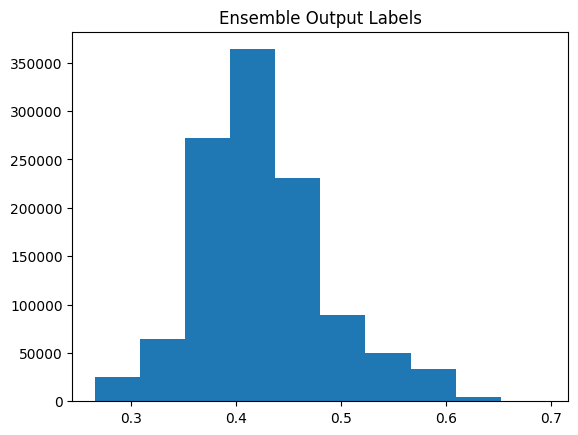

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(ensemble_output.flatten())
plt.title("Ensemble Output Labels")
plt.show()

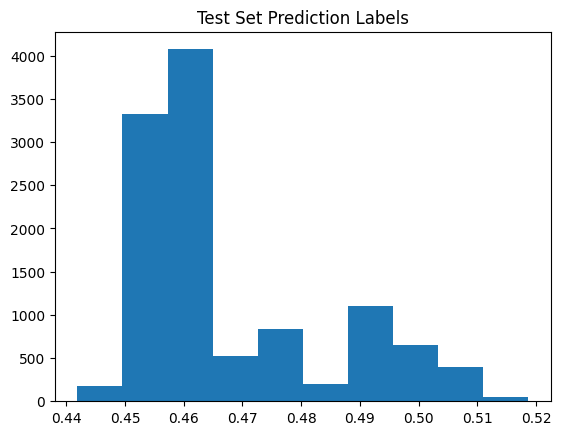

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(mean_pred)
plt.title("Test Set Prediction Labels")
plt.show()

# Graphs

## Training Data

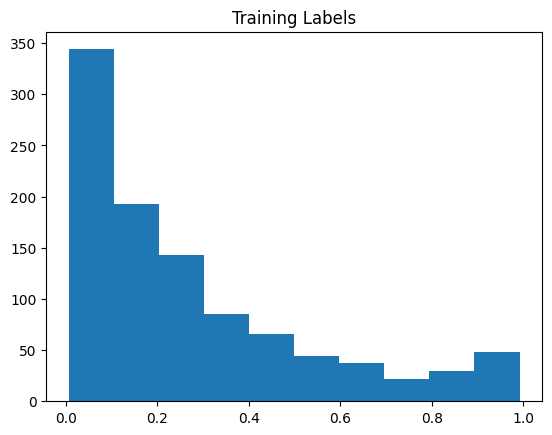

In [66]:
plt.hist(y_train.cpu().numpy())
plt.title("Training Labels")
plt.show()

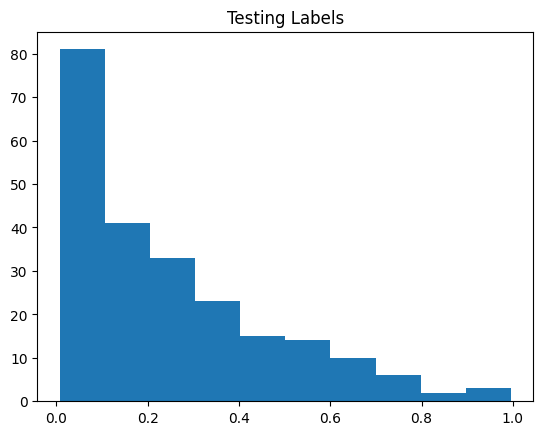

In [67]:
plt.hist(y_test.cpu().numpy())
plt.title("Testing Labels")
plt.show()

## Eval on Training Set

In [80]:
ensemble_output = np.column_stack([model.predict(X_train.cpu().numpy()) for model in lgb_boot_models])
mean_pred = meta_model.predict(ensemble_output)
ensemble_output.shape, mean_pred.shape

((912, 100), (912,))

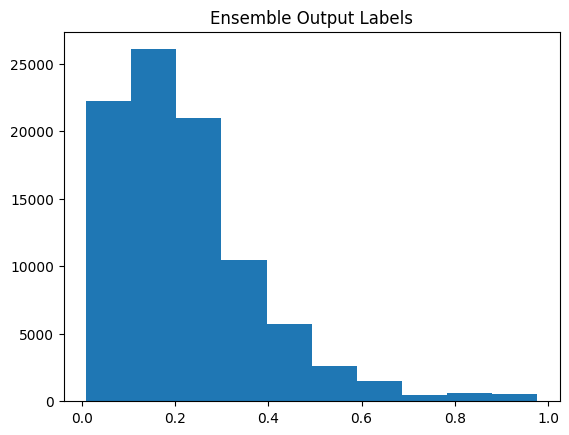

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(ensemble_output.flatten())
plt.title("Ensemble Output Labels")
plt.show()

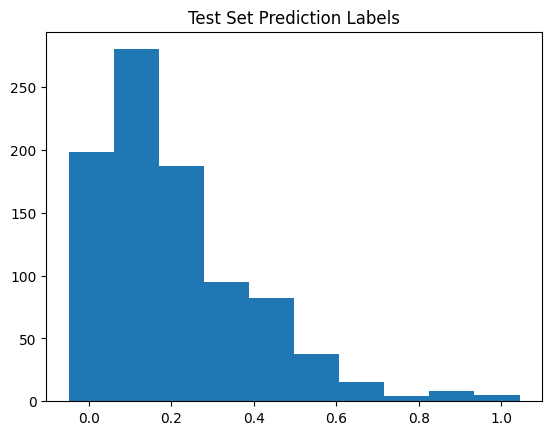

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(mean_pred)
plt.title("Test Set Prediction Labels")
plt.show()

## Query 1 Eval

In [84]:
# load and merge in query 1 results
df_query1 = pd.read_csv('query1.csv')
df_query1.rename(columns={"sequence": "Sequence"}, inplace=True)

# develop embeddings
df_query1["Embedding"] = df_query1["Sequence"].apply(lambda seq: extract_esm_embedding(seq))


In [96]:
X_query1 = np.vstack(df_query1["Embedding"].values)
y_query1 = df_query1["DMS_score"].values.reshape(-1, 1)
ensemble_output = np.column_stack([model.predict(X_query1) for model in lgb_boot_models])
mean_pred = ensemble_output.mean(axis=1)#meta_model.predict(ensemble_output)
ensemble_output.shape, mean_pred.shape

((100, 100), (100,))

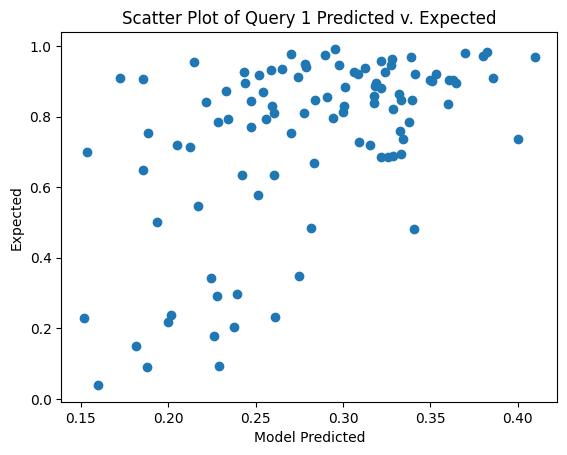

In [97]:
plt.scatter(mean_pred, y_query1)
plt.title("Scatter Plot of Query 1 Predicted v. Expected")
plt.xlabel("Model Predicted")
plt.ylabel("Expected")
plt.show()

In [98]:
from scipy.stats import spearmanr
corr, p_value = spearmanr(mean_pred, y_query1)
corr

np.float64(0.4742274227422742)

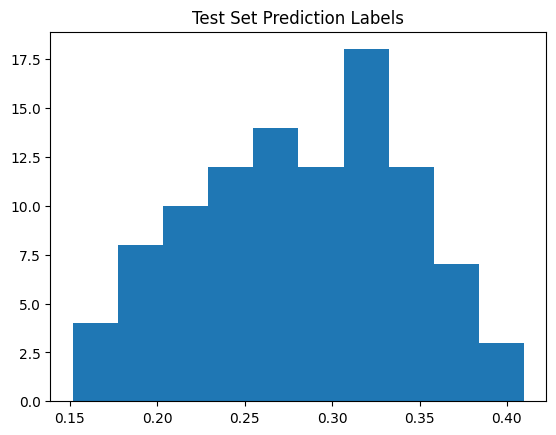

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(mean_pred)
plt.title("Test Set Prediction Labels")
plt.show()

In [56]:
first = pd.read_csv('query1.csv')

In [3]:
queries = pd.concat((pd.read_csv('query1.csv'),pd.read_csv('query2.csv')), axis=0).reset_index()

In [5]:
import numpy as np
percentiles = np.percentile(queries['DMS_score'], [10, 20, 30, 40, 50, 60, 70, 80, 90])

percentiles

array([0.4152002 , 0.64607854, 0.74061055, 0.79687417, 0.84016802,
       0.86994904, 0.89787522, 0.92119429, 0.95439245])

(array([ 4.,  5.,  6.,  6.,  7., 10., 12., 31., 57., 62.]),
 array([0.03988869, 0.13504084, 0.23019299, 0.32534514, 0.42049729,
        0.51564944, 0.61080158, 0.70595373, 0.80110588, 0.89625803,
        0.99141018]),
 <BarContainer object of 10 artists>)

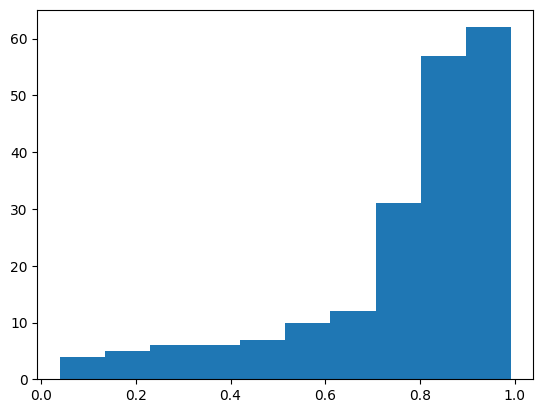

In [61]:
plt.hist(queries['DMS_score'])

In [93]:
ground = set(queries[queries['DMS_score'] >=.9]['mutant'].values)

In [90]:
len(ground.intersection(set(predicted_top))) / len(predicted_top)

0.13

In [96]:
sofar = ['Q266K',
'G186I',
'N648L',
'N486I',
'G6I',
'N546I',
'N546L',
'N546W',
'N486W',
'N486L',
'N546W',
'D622W',
'A654W',
'D637W',
'D613W',
'A649W',
'D628W',
'S604W',
'S602W',
'G595W'
]

In [102]:
set(sofar).intersection(set(queries['DMS_score'].values))

set()

In [100]:
for i in df_test['mutant']:
    if i in sofar:
        print(i,df_test[df_test['mutant']==i]['DMS_score_predicted'])

G6I 105    0.573443
Name: DMS_score_predicted, dtype: float64
G186I 3249    0.162068
Name: DMS_score_predicted, dtype: float64
Q266K 4390    0.518798
Name: DMS_score_predicted, dtype: float64
N486I 8101    0.821475
Name: DMS_score_predicted, dtype: float64
N486L 8103    0.8545
Name: DMS_score_predicted, dtype: float64
N486W 8110    0.702023
Name: DMS_score_predicted, dtype: float64
N546L 9234    0.902992
Name: DMS_score_predicted, dtype: float64
N546W 9237    0.785087
Name: DMS_score_predicted, dtype: float64
N546I 9243    0.795036
Name: DMS_score_predicted, dtype: float64
G595W 10171    0.713087
Name: DMS_score_predicted, dtype: float64
S602W 10298    0.753045
Name: DMS_score_predicted, dtype: float64
S604W 10344    0.731129
Name: DMS_score_predicted, dtype: float64
D613W 10509    0.664903
Name: DMS_score_predicted, dtype: float64
D622W 10693    0.727425
Name: DMS_score_predicted, dtype: float64
D628W 10808    0.686278
Name: DMS_score_predicted, dtype: float64
D637W 10974    0.772451
